<a href="https://colab.research.google.com/github/swampxx/ML-algorithms-on-ids-datasets/blob/master/NSL-KDD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1: Data preprocessing
## Step 2: Feature Scaling
## Step 3: Feature Selection
## Step 4: Build Models
## Step 5: Evaluate Models


### Dataset Information

It is important to note that the test data is not from the same probability distribution as the training data, and it includes specific attack types not in the training data. This makes the task more realistic. Some intrusion experts believe that most novel attacks are variants of known attacks and the "signature" of known attacks can be sufficient to catch novel variants. The datasets contain a total of 24 training attack types, with an additional 14 types in the test data only.

More info: http://kdd.ics.uci.edu/databases/kddcup99/task.html

In [1]:
########################################################## Directly Download ##########################################################

# !wget http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz                                  # The full data set
# !wget http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz                       # A 10% subset
# !wget http://kdd.ics.uci.edu/databases/kddcup99/kddcup.newtestdata_10_percent_unlabeled.gz      # 10% unlabeled
# !wget http://kdd.ics.uci.edu/databases/kddcup99/kddcup.testdata.unlabeled.gz
# !wget http://kdd.ics.uci.edu/databases/kddcup99/kddcup.testdata.unlabeled_10_percent.gz
# !wget http://kdd.ics.uci.edu/databases/kddcup99/corrected.gz                                    # Test data with corrected labels

# Copy to Drive
# !cp *.gz drive/My\ Drive/Colab\ Notebooks/DataSets/Original/

## Environment Setup

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (precision_score, recall_score,f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import (precision_score, recall_score,f1_score, accuracy_score,mean_squared_error,mean_absolute_error, roc_curve, classification_report,auc)
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import itertools
import matplotlib.pyplot as plt

# Print Dataset without any kind of truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

#Plot settings
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## Load Datasets

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [4]:
# Original Data: https://github.com/defcom17/NSL_KDD/blob/master/Original%20NSL%20KDD%20Zip.zip

!cp drive/My\ Drive/Colab\ Notebooks/DataSets/KDDTrain.csv ./
!cp drive/My\ Drive/Colab\ Notebooks/DataSets/KDDTest.csv ./

In [5]:
def loadDataSets():
  
    col_names = ["duration","protocol_type","service","flag","src_bytes",
        "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
        "logged_in","num_compromised","root_shell","su_attempted","num_root",
        "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
        "is_host_login","is_guest_login","count","srv_count","serror_rate",
        "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
        "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
        "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
        "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
        "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

    # # Load NSL_KDD train dataset
    # df = pd.read_table("KDDTrain.txt", sep=",", names=col_names)
    # df = df.iloc[:,:-1] # removes an unwanted extra field

    # # Load NSL_KDD test dataset
    # df_test = pd.read_table("KDDTest.txt", sep=",", names=col_names)
    # df_test = df_test.iloc[:,:-1]

    df_train = pd.read_csv("KDDTrain.csv", header=None, names = col_names)
    df_test  = pd.read_csv("KDDTest.csv",  header=None, names = col_names)

    print('Training set dimensions: {} --- Test set dimensions: {}'.format(df_train.shape, df_test.shape))

    return df_train, df_test

df_train, df_test = loadDataSets()

Training set dimensions: (125973, 42) --- Test set dimensions: (22544, 42)


## Analyze Datasets

### Value Counts

In [6]:
def valueCounts(df):
    print("########## VALUE COUNTS OF CATEROGICAL COLUMNS ##########")
    for colName in df.columns:
        if df[colName].dtypes == 'object':  # Only consider caterogical columns
            uniqueCat = len(df[colName].unique())
            print()
            print('### {colName} has {uniqueCat} categories:'.format(colName=colName, uniqueCat=uniqueCat))
            print(df[colName].value_counts())

In [7]:
valueCounts(df_train)
df_train.describe()

########## VALUE COUNTS OF CATEROGICAL COLUMNS ##########

### protocol_type has 3 categories:
tcp     102689
udp      14993
icmp      8291
Name: protocol_type, dtype: int64

### service has 70 categories:
http           40338
private        21853
domain_u        9043
smtp            7313
ftp_data        6860
eco_i           4586
other           4359
ecr_i           3077
telnet          2353
finger          1767
ftp             1754
auth             955
Z39_50           862
uucp             780
courier          734
bgp              710
whois            693
uucp_path        689
iso_tsap         687
time             654
imap4            647
nnsp             630
vmnet            617
urp_i            602
domain           569
ctf              563
csnet_ns         545
supdup           544
discard          538
http_443         530
daytime          521
gopher           518
efs              485
systat           477
link             475
exec             474
hostnames        460
name             

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.0,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,0.001342,0.001103,0.302192,0.012669,0.000413,0.004096,0.0,0.000008,0.009423,84.107555,27.737888,0.284485,0.282485,0.119958,0.121183,0.660928,0.063053,0.097322,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,0.036603,0.045154,24.399618,0.483935,0.022181,0.099370,0.0,0.002817,0.096612,114.508607,72.635840,0.446456,0.447022,0.320436,0.323647,0.439623,0.180314,0.259830,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.0,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
valueCounts(df_test)
df_test.describe()

########## VALUE COUNTS OF CATEROGICAL COLUMNS ##########

### protocol_type has 3 categories:
tcp     18880
udp      2621
icmp     1043
Name: protocol_type, dtype: int64

### service has 64 categories:
http           7853
private        4774
telnet         1626
pop_3          1019
smtp            934
domain_u        894
ftp_data        851
other           838
ecr_i           752
ftp             692
imap4           306
eco_i           262
sunrpc          159
finger          136
auth             67
domain           51
uucp             50
iso_tsap         48
uucp_path        46
bgp              46
Z39_50           45
vmnet            43
nnsp             42
link             41
ctf              41
whois            40
courier          40
echo             37
name             37
http_443         36
netbios_ns       36
time             36
gopher           34
csnet_ns         34
efs              33
systat           32
mtp              32
login            29
daytime          28
exec             

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,22544.000000,2.254400e+04,2.254400e+04,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.0,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000
mean,218.859076,1.039545e+04,2.056019e+03,0.000311,0.008428,0.000710,0.105394,0.021647,0.442202,0.119899,0.002440,0.000266,0.114665,0.008738,0.001153,0.003549,0.0,0.000488,0.028433,79.028345,31.124379,0.102924,0.103635,0.238463,0.235179,0.740345,0.094074,0.098110,193.869411,140.750532,0.608722,0.090540,0.132261,0.019638,0.097814,0.099426,0.233385,0.226683
std,1407.176612,4.727864e+05,2.121930e+04,0.017619,0.142599,0.036473,0.928428,0.150328,0.496659,7.269597,0.049334,0.021060,8.041614,0.676842,0.048014,0.067829,0.0,0.022084,0.166211,128.539248,89.062532,0.295367,0.298332,0.416118,0.416215,0.412496,0.259138,0.253545,94.035663,111.783972,0.435688,0.220717,0.306268,0.085394,0.273139,0.281866,0.387229,0.400875
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,121.000000,15.000000,0.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.400000e+01,4.600000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,8.000000,6.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,168.000000,0.920000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.870000e+02,6.010000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,123.250000,16.000000,0.000000,0.000000,0.250000,0.072500,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.060000,0.030000,0.010000,0.000000,0.000000,0.360000,0.170000
max,57715.000000,6.282565e+07,1.345927e+06,1.000000,3.000000,3.000000,101.000000,4.000000,1.000000,796.000000,1.000000,2.000000,878.000000,100.000000,5.000000,4.000000,0.0,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Label Distribution

In [9]:
# Rename every attack label: 0=normal, 1=DoS, 2=Probe, 3=R2L and 4=U2R
def mappingLabel(df):
    mapping = { 'normal'       : 0, 'neptune'  : 1, 'back'        : 1, 'land'       : 1, 'pod'        : 1, 'smurf'          : 1, 'teardrop'  : 1,
                'mailbomb'     : 1, 'apache2'  : 1, 'processtable': 1, 'udpstorm'   : 1, 'worm'       : 1, 'ipsweep'        : 2, 'nmap'      : 2,
                'portsweep'    : 2, 'satan'    : 2, 'mscan'       : 2, 'saint'      : 2, 'ftp_write'  : 3, 'guess_passwd'   : 3, 'imap'      : 3,
                'multihop'     : 3, 'phf'      : 3, 'spy'         : 3, 'warezclient': 3, 'warezmaster': 3, 'sendmail'       : 3, 'named'     : 3,
                'snmpgetattack': 3, 'snmpguess': 3, 'xlock'       : 3, 'xsnoop'     : 3, 'httptunnel' : 3, 'buffer_overflow': 4, 'loadmodule': 4,
                'perl'         : 4, 'rootkit'  : 4, 'ps'          : 4, 'sqlattack'  : 4, 'xterm'      : 4
            }

    # Apply attack type mapping to the dataset
    mappedLabel = df['label'].apply(lambda v: mapping[v])

    return mappedLabel

mappedLabel_train = mappingLabel(df_train)
mappedLabel_test  = mappingLabel(df_test)

df_train['mappedLabel'] = mappedLabel_train
df_test['mappedLabel'] = mappedLabel_test

# Label Distribution
label_freq_train = df_train[['mappedLabel']].apply(lambda x: x.value_counts())
label_freq_test  = df_test[['mappedLabel']].apply(lambda x: x.value_counts())
label_freq_train['frequency_percent_train'] = round((100 * label_freq_train / label_freq_train.sum()),2)
label_freq_test ['frequency_percent_test' ] = round((100 * label_freq_test  / label_freq_test. sum()),2)

df_train.drop(['mappedLabel'], axis=1, inplace=True)
df_test.drop(['mappedLabel'], axis=1, inplace=True)

label_dist = pd.concat([label_freq_train,label_freq_test], axis=1) 
label_dist

,mappedLabel,frequency_percent_train,mappedLabel,frequency_percent_test
0,67343,53.46,9711,43.08
1,45927,36.46,7460,33.09
2,11656,9.25,2421,10.74
3,995,0.79,2885,12.80
4,52,0.04,67,0.30


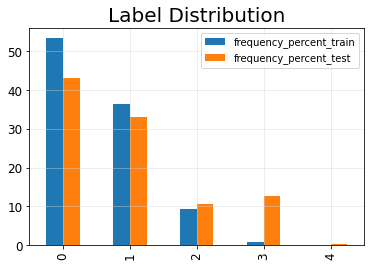

In [10]:
# Plot Label Distribution
plot = label_dist[['frequency_percent_train', 'frequency_percent_test']].plot(kind="bar")
plot.set_title("Label Distribution", fontsize=20)
plot.grid(color='lightgray', alpha=0.5)

## Preprocessing

In [20]:
def preprocessing(df, serviceDifference = None):

    ## One-Hot-Encoding (one-of-K) is used to to transform all categorical features into binary features.
    ## For that, the features first need to be transformed with LabelEncoder, to transform every category to a number.

    categorical_columns = ['protocol_type', 'service', 'flag']

    # Get the categorical columns
    df_categorical_columns = df[categorical_columns]

    ## Transform categorical features into numbers using LabelEncoder()
    df_categorical_columns = df_categorical_columns.apply(LabelEncoder().fit_transform)

    ## We need to make dummie columns for all caterogical columns since their distribution is almost even. 
    unique_protocol = sorted(df.protocol_type.unique())
    unique_protocol = ['protocol_type_' + x for x in unique_protocol]

    unique_service = sorted(df.service.unique())
    unique_service = ['service_' + x for x in unique_service]

    unique_flag = sorted(df.flag.unique())
    unique_flag = ['flag_' + x for x in unique_flag]

    dumcols = unique_protocol + unique_service + unique_flag

    ## One-Hot Encoding
    enc = OneHotEncoder()
    df_categorical_columns = enc.fit_transform(df_categorical_columns)
    df_categorical_columns = pd.DataFrame(df_categorical_columns.toarray(), columns=dumcols)

    if serviceDifference != None:   # Add 6 missing categories to test dataset

        string = 'service_'
        difference = [string + x for x in serviceDifference]

        for col in difference:
            df_categorical_columns[col] = 0

    ## Join encoded categorical dataframe with the non-categorical dataframe
    newdf = df.join(df_categorical_columns)
    newdf.drop(['protocol_type', 'service', 'flag'], axis=1, inplace=True)


    ## Split Dataset into 4 datasets for every attack category
    # Rename every attack label: 0=normal, 1=DoS, 2=Probe, 3=R2L and 4=U2R
    newdf['label'] = mappingLabel(newdf)

    DoS   = newdf[~newdf['label'].isin([2,3,4])]
    PROBE = newdf[~newdf['label'].isin([1,3,4])]
    R2L   = newdf[~newdf['label'].isin([1,2,4])]
    U2L   = newdf[~newdf['label'].isin([1,2,3])]

    return DoS, PROBE, R2L, U2L


service_train = df_train['service'].tolist()
service_test  = df_test ['service'].tolist()
serviceDifference = list(set(service_train) - set(service_test))

DoS_train, PROBE_train, R2L_train, U2R_train = preprocessing(df_train)
DoS_test, PROBE_test, R2L_test, U2R_test = preprocessing(df_test, serviceDifference)

print("TRAIN DATA SHAPE")
print(DoS_train.shape)
print(PROBE_train.shape)
print(R2L_train.shape)
print(U2R_train.shape)

print("TEST DATA SHAPE")
print(DoS_test.shape)
print(PROBE_test.shape)
print(R2L_test.shape)
print(U2R_test.shape)

TRAIN DATA SHAPE
(113270, 123)
(78999, 123)
(68338, 123)
(67395, 123)
TEST DATA SHAPE
(17171, 123)
(12132, 123)
(12596, 123)
(9778, 123)


## Feauture Scaling

In [21]:
from sklearn import preprocessing
def featureScaling(attack_type):

    features = attack_type.drop('label', 1)
    label = attack_type.label

    #Save a list of feature names for later use (it is the same for every attack category). 
    # Column names are dropped at this stage.
    colNames = list(features)

    # Use StandardScaler() to scale the dataframes
    scaler = preprocessing.StandardScaler().fit(features)
    features = scaler.transform(features)

    #Check if Standard Deviation is 1
    #print(features.std(axis=0))

    return features, colNames, label

# Train
features_DoS_train,   colNames_DoS_train,   label_DoS_train   = featureScaling(DoS_train)
features_PROBE_train, colNames_PROBE_train, label_PROBE_train = featureScaling(PROBE_train)
features_R2L_train,   colNames_R2L_train,   label_R2L_train   = featureScaling(R2L_train)
features_U2R_train,   colNames_U2R_train,   label_U2R_train   = featureScaling(U2R_train)

# Test
features_DoS_test,   colNames_DoS_test,   label_DoS_test   = featureScaling(DoS_test)
features_PROBE_test, colNames_PROBE_test, label_PROBE_test = featureScaling(PROBE_test)
features_R2L_test,   colNames_R2L_test,   label_R2L_test   = featureScaling(R2L_test)
features_U2R_test,   colNames_U2R_test,   label_U2R_test   = featureScaling(U2R_test)

## Feature Selection

['src_bytes', 'dst_bytes', 'wrong_fragment', 'num_compromised', 'same_srv_rate', 'diff_srv_rate', 'dst_host_count', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'service_ecr_i', 'flag_RSTR', 'flag_S0']
['src_bytes', 'dst_bytes', 'rerror_rate', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_rerror_rate', 'service_finger', 'service_ftp_data', 'service_http', 'service_private', 'service_smtp', 'service_telnet']
['duration', 'src_bytes', 'dst_bytes', 'hot', 'num_failed_logins', 'num_access_files', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'service_ftp_data', 'service_imap4']
['duration', 'src_bytes', 'dst_bytes', 'hot', 'root_shell', 'num_file_creations', 'num_shells', 'srv_count', 'dst_host_count', 'dst_host_same_srv_rate', 'dst_host_srv_diff_host_rate', 'service_ftp_data', 'service_other']


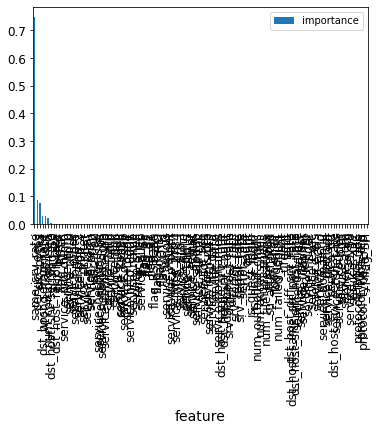

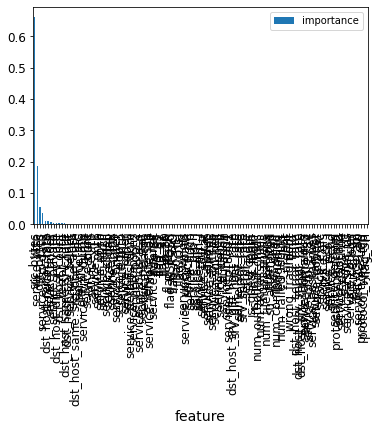

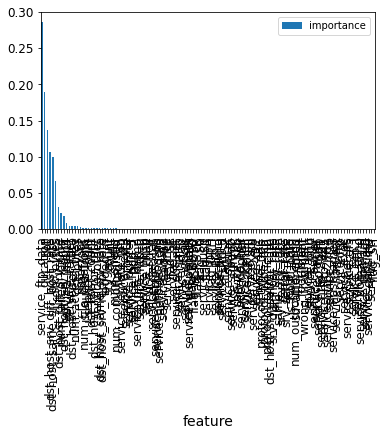

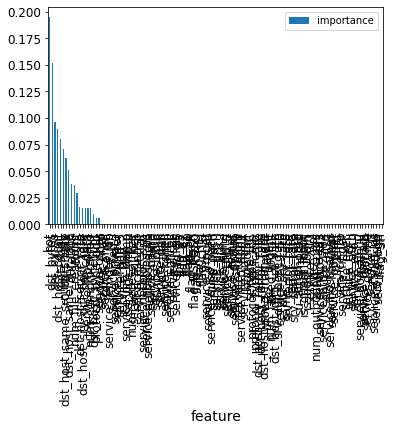

In [22]:
def featureSelection(features, colNames, label):
    clf = DecisionTreeClassifier(random_state=0)
    #clf = RandomForestClassifier(random_state=0)
    
    rfe = RFE(estimator=clf, n_features_to_select=13, step=1)
    rfe.fit(features, label)
    features_rfe = rfe.transform(features)
    true = rfe.support_
    rfecolindex = [i for i, x in enumerate(true) if x]
    selectedFeatures = list(colNames[i] for i in rfecolindex)

    #featureMap = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), colNames)]
    #selectedFeatures = [v for i, v in featureMap if i==True]

    # Features selected by RFE
    print(selectedFeatures)

    ## Plot
    clf2 = DecisionTreeClassifier(random_state=0)
    clf2.fit(features, label)

    # extract important features
    score = np.round(clf2.feature_importances_, 3)
    importances = pd.DataFrame({'feature':colNames,'importance':score})
    importances = importances.sort_values('importance',ascending=False).set_index('feature')
    
    # plot importances
    #plt.rcParams['figure.figsize'] = (11, 4)
    importances.plot.bar();
    
    return features_rfe, rfecolindex

# Train
selectedFeatures_DoS_train,   selectedFeaturesIndex_DoS_train   = featureSelection(features_DoS_train,   colNames_DoS_train,   label_DoS_train  )
selectedFeatures_PROBE_train, selectedFeaturesIndex_PROBE_train = featureSelection(features_PROBE_train, colNames_PROBE_train, label_PROBE_train)
selectedFeatures_R2L_train,   selectedFeaturesIndex_R2L_train   = featureSelection(features_R2L_train,   colNames_R2L_train,   label_R2L_train  )
selectedFeatures_U2R_train,   selectedFeaturesIndex_U2R_train   = featureSelection(features_U2R_train,   colNames_U2R_train,   label_U2R_train  )

## Build and Test Machine Learning Models

### Function Implementations

In [14]:
#NOTE: typeFunc should be given WITHOUT paranteses
def buildModel(trainData, trainLabel, typeFunc, **args):
    model = typeFunc(**args)
    model.fit(trainData, trainLabel)
    return model

In [29]:
def printMetrics(model, testData, testLabel):

    predictedLabel = model.predict(testData)

    print("Confusion Matrix")
    print(confusion_matrix(testLabel, predictedLabel))
    print()
    print(classification_report(testLabel, predictedLabel))

    print("### CV=10 RESULTS ###")
    accuracy = cross_val_score(model, testData, testLabel, cv=10, scoring='accuracy')
    precision = cross_val_score(model, testData, testLabel, cv=10, scoring='precision_macro')
    recall = cross_val_score(model, testData, testLabel, cv=10, scoring='recall_macro')
    f1= cross_val_score(model, testData, testLabel, cv=10, scoring='f1_macro')
    print("Accuracy : %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
    print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
    print("Recall   : %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
    print("F-measure: %0.5f (+/- %0.5f)" % (f1.mean(), f1.std() * 2))

In [24]:
def testAllModels(attackType, features_train, label_train, features_test, label_test, selectedFeatures_train, selectedFeaturesIndex_train):

    print()
    print("###############################################################################################")
    print(f"##################################  {attackType}  ############################################")
    print("###############################################################################################")
    print()
    print("-----------------------------------------LR---------------------------------") # DON'T CONVERGE
    print()
    print("--------- ALL FEATURES --------")
    #lr = buildModel(features_train, label_train, LogisticRegression)
    #printMetrics(lr, features_test, label_test)
    print()
    print("------ SELECTED FEATURES ------")
    #lr = buildModel(selectedFeatures_train, label_train, LogisticRegression)
    #printMetrics(lr, features_test[:,selectedFeaturesIndex_train], label_test)

    print("-----------------------------------------NB---------------------------------")
    print()
    print("--------- ALL FEATURES --------")
    nb = buildModel(features_train, label_train, GaussianNB)
    printMetrics(nb, features_test, label_test)
    print()
    print("------ SELECTED FEATURES ------")
    nb = buildModel(selectedFeatures_train, label_train, GaussianNB)
    printMetrics(nb, features_test[:,selectedFeaturesIndex_train], label_test)

    print("-----------------------------------------KNN---------------------------------")
    print()
    print("--------- ALL FEATURES --------")
    knn = buildModel(features_train, label_train, KNeighborsClassifier)
    printMetrics(knn, features_test, label_test)
    print()
    print("------ SELECTED FEATURES ------")
    knn = buildModel(selectedFeatures_train, label_train, KNeighborsClassifier)
    printMetrics(knn, features_test[:,selectedFeaturesIndex_train], label_test)

    print("-----------------------------------------DT---------------------------------")
    print()
    print("--------- ALL FEATURES --------")
    dt = buildModel(features_train, label_train, DecisionTreeClassifier)
    printMetrics(dt, features_test, label_test)
    print()
    print("------ SELECTED FEATURES ------")
    dt = buildModel(selectedFeatures_train, label_train, DecisionTreeClassifier)
    printMetrics(dt, features_test[:,selectedFeaturesIndex_train], label_test)

    print("-------------------------------------Adaboost---------------------------------")
    print()
    print("--------- ALL FEATURES --------")
    adaboost = buildModel(features_train, label_train, AdaBoostClassifier, n_estimators=100)
    printMetrics(adaboost, features_test, label_test)
    print()
    print("------ SELECTED FEATURES ------")
    adaboost = buildModel(selectedFeatures_train, label_train, AdaBoostClassifier, n_estimators=100)
    printMetrics(adaboost, features_test[:,selectedFeaturesIndex_train], label_test)

    print("-------------------------------------RandomForest---------------------------------")
    print()
    print("--------- ALL FEATURES --------")
    rf = buildModel(features_train, label_train, RandomForestClassifier, n_estimators=100)
    printMetrics(rf, features_test, label_test)
    print()
    print("------ SELECTED FEATURES ------")
    rf = buildModel(selectedFeatures_train, label_train, RandomForestClassifier, n_estimators=100)
    printMetrics(rf, features_test[:,selectedFeaturesIndex_train], label_test)

    print("-----------------------------------------SVM_rbf---------------------------------")
    print()
    print("--------- ALL FEATURES --------")
    #svm_rbf = buildModel(features_train, label_train, svm.SVC, kernel='rbf',probability=True)
    #printMetrics(svm_rbf, features_test, label_test)
    print()
    print("------ SELECTED FEATURES ------")
    #svm_rbf = buildModel(selectedFeatures_train, label_train, svm.SVC, kernel='rbf',probability=True)
    #printMetrics(svm_rbf, features_test[:,selectedFeaturesIndex_train], label_test)

### DoS Testing

In [17]:
testAllModels("DoS", features_DoS_train, label_DoS_train, features_DoS_test, label_DoS_test, selectedFeatures_DoS_train, selectedFeaturesIndex_DoS_train)


###############################################################################################
##################################  DoS  ############################################
###############################################################################################

-----------------------------------------LR---------------------------------

--------- ALL FEATURES --------

------ SELECTED FEATURES ------
-----------------------------------------NB---------------------------------

--------- ALL FEATURES --------
Confusion Matrix
[[9447  264]
 [3701 3759]]

              precision    recall  f1-score   support

           0       0.72      0.97      0.83      9711
           1       0.93      0.50      0.65      7460

    accuracy                           0.77     17171
   macro avg       0.83      0.74      0.74     17171
weighted avg       0.81      0.77      0.75     17171

### CV=10 RESULTS ###
Accuracy : 0.86733 (+/- 0.01474)
Precision: 0.98822 (+/- 0.01158)
Recall 

### PROBE  Testing

In [30]:
testAllModels("PROBE", features_PROBE_train, label_PROBE_train, features_PROBE_test, label_PROBE_test, selectedFeatures_PROBE_train, selectedFeaturesIndex_PROBE_train)


###############################################################################################
##################################  PROBE  ############################################
###############################################################################################

-----------------------------------------LR---------------------------------

--------- ALL FEATURES --------

------ SELECTED FEATURES ------
-----------------------------------------NB---------------------------------

--------- ALL FEATURES --------
Confusion Matrix
[[  76 9635]
 [ 201 2220]]

              precision    recall  f1-score   support

           0       0.27      0.01      0.02      9711
           2       0.19      0.92      0.31      2421

    accuracy                           0.19     12132
   macro avg       0.23      0.46      0.16     12132
weighted avg       0.26      0.19      0.07     12132

### CV=10 RESULTS ###
Accuracy : 0.97898 (+/- 0.01148)
Precision: 0.97323 (+/- 0.00912)
Recal

### R2L Testing

In [31]:
testAllModels("R2L", features_R2L_train, label_R2L_train, features_R2L_test, label_R2L_test, selectedFeatures_R2L_train, selectedFeaturesIndex_R2L_train)


###############################################################################################
##################################  R2L  ############################################
###############################################################################################

-----------------------------------------LR---------------------------------

--------- ALL FEATURES --------

------ SELECTED FEATURES ------
-----------------------------------------NB---------------------------------

--------- ALL FEATURES --------
Confusion Matrix
[[9711    0]
 [2885    0]]

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      9711
           3       0.00      0.00      0.00      2885

    accuracy                           0.77     12596
   macro avg       0.39      0.50      0.44     12596
weighted avg       0.59      0.77      0.67     12596

### CV=10 RESULTS ###


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy : 0.93562 (+/- 0.01004)
Precision: 0.89097 (+/- 0.01367)
Recall   : 0.95508 (+/- 0.00771)
F-measure: 0.91620 (+/- 0.01200)

------ SELECTED FEATURES ------
-----------------------------------------KNN---------------------------------

--------- ALL FEATURES --------
Confusion Matrix
[[9706    5]
 [2883    2]]

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      9711
           3       0.29      0.00      0.00      2885

    accuracy                           0.77     12596
   macro avg       0.53      0.50      0.44     12596
weighted avg       0.66      0.77      0.67     12596

### CV=10 RESULTS ###
Accuracy : 0.96737 (+/- 0.00730)
Precision: 0.95311 (+/- 0.01274)
Recall   : 0.95484 (+/- 0.01326)
F-measure: 0.95389 (+/- 0.01030)

------ SELECTED FEATURES ------
Confusion Matrix
[[9710    1]
 [2885    0]]

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      9711
           

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy : 0.98047 (+/- 0.01035)
Precision: 0.97156 (+/- 0.01634)
Recall   : 0.97332 (+/- 0.01421)
F-measure: 0.97241 (+/- 0.01453)

------ SELECTED FEATURES ------
Confusion Matrix
[[9710    1]
 [2885    0]]

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      9711
           3       0.00      0.00      0.00      2885

    accuracy                           0.77     12596
   macro avg       0.39      0.50      0.44     12596
weighted avg       0.59      0.77      0.67     12596

### CV=10 RESULTS ###
Accuracy : 0.96412 (+/- 0.01083)
Precision: 0.95217 (+/- 0.01562)
Recall   : 0.94567 (+/- 0.01767)
F-measure: 0.94882 (+/- 0.01563)
-------------------------------------RandomForest---------------------------------

--------- ALL FEATURES --------
Confusion Matrix
[[9711    0]
 [2885    0]]

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      9711
           3       0.00      0.00      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy : 0.98134 (+/- 0.00735)
Precision: 0.97391 (+/- 0.00933)
Recall   : 0.97290 (+/- 0.01171)
F-measure: 0.97418 (+/- 0.01043)

------ SELECTED FEATURES ------
Confusion Matrix
[[9711    0]
 [2885    0]]

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      9711
           3       0.00      0.00      0.00      2885

    accuracy                           0.77     12596
   macro avg       0.39      0.50      0.44     12596
weighted avg       0.59      0.77      0.67     12596

### CV=10 RESULTS ###


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy : 0.97602 (+/- 0.00618)
Precision: 0.96894 (+/- 0.01261)
Recall   : 0.96409 (+/- 0.01318)
F-measure: 0.96643 (+/- 0.00860)
-----------------------------------------SVM_rbf---------------------------------

--------- ALL FEATURES --------

------ SELECTED FEATURES ------


### U2R Testing

In [32]:
testAllModels("U2R", features_U2R_train, label_U2R_train, features_U2R_test, label_U2R_test, selectedFeatures_U2R_train, selectedFeaturesIndex_U2R_train)


###############################################################################################
##################################  U2R  ############################################
###############################################################################################

-----------------------------------------LR---------------------------------

--------- ALL FEATURES --------

------ SELECTED FEATURES ------
-----------------------------------------NB---------------------------------

--------- ALL FEATURES --------
Confusion Matrix
[[9711    0]
 [  67    0]]

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9711
           4       0.00      0.00      0.00        67

    accuracy                           0.99      9778
   macro avg       0.50      0.50      0.50      9778
weighted avg       0.99      0.99      0.99      9778

### CV=10 RESULTS ###


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy : 0.97259 (+/- 0.01129)
Precision: 0.60157 (+/- 0.03254)
Recall   : 0.97911 (+/- 0.04300)
F-measure: 0.66091 (+/- 0.04790)

------ SELECTED FEATURES ------
-----------------------------------------KNN---------------------------------

--------- ALL FEATURES --------
Confusion Matrix
[[9711    0]
 [  65    2]]

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9711
           4       1.00      0.03      0.06        67

    accuracy                           0.99      9778
   macro avg       1.00      0.51      0.53      9778
weighted avg       0.99      0.99      0.99      9778

### CV=10 RESULTS ###
Accuracy : 0.99703 (+/- 0.00281)
Precision: 0.93143 (+/- 0.14679)
Recall   : 0.85073 (+/- 0.17639)
F-measure: 0.87831 (+/- 0.11390)

------ SELECTED FEATURES ------
Confusion Matrix
[[9709    2]
 [  60    7]]

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9711
           

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy : 0.99785 (+/- 0.00371)
Precision: 0.94541 (+/- 0.14838)
Recall   : 0.89488 (+/- 0.18165)
F-measure: 0.91393 (+/- 0.14871)

------ SELECTED FEATURES ------
Confusion Matrix
[[9711    0]
 [  67    0]]

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9711
           4       0.00      0.00      0.00        67

    accuracy                           0.99      9778
   macro avg       0.50      0.50      0.50      9778
weighted avg       0.99      0.99      0.99      9778

### CV=10 RESULTS ###


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy : 0.99673 (+/- 0.00286)
Precision: 0.93401 (+/- 0.14440)
Recall   : 0.82459 (+/- 0.16751)
F-measure: 0.86255 (+/- 0.11751)
-------------------------------------RandomForest---------------------------------

--------- ALL FEATURES --------
Confusion Matrix
[[9711    0]
 [  67    0]]

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9711
           4       0.00      0.00      0.00        67

    accuracy                           0.99      9778
   macro avg       0.50      0.50      0.50      9778
weighted avg       0.99      0.99      0.99      9778

### CV=10 RESULTS ###


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy : 0.99795 (+/- 0.00204)
Precision: 0.95443 (+/- 0.11916)
Recall   : 0.90450 (+/- 0.12739)
F-measure: 0.90623 (+/- 0.11486)

------ SELECTED FEATURES ------
Confusion Matrix
[[9711    0]
 [  60    7]]

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9711
           4       1.00      0.10      0.19        67

    accuracy                           0.99      9778
   macro avg       1.00      0.55      0.59      9778
weighted avg       0.99      0.99      0.99      9778

### CV=10 RESULTS ###
Accuracy : 0.99765 (+/- 0.00290)
Precision: 0.97397 (+/- 0.10689)
Recall   : 0.86056 (+/- 0.18516)
F-measure: 0.89925 (+/- 0.10262)
-----------------------------------------SVM_rbf---------------------------------

--------- ALL FEATURES --------

------ SELECTED FEATURES ------
